In [1]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
import copulas
from copulas.multivariate import GaussianMultivariate

In [2]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

# Cleaning
df = df.drop(columns=['Ref#'])
df['Raw Material'] = df['Raw Material'].str.title()

# Substitute every NaN with 'NA'
df = df.fillna('0')

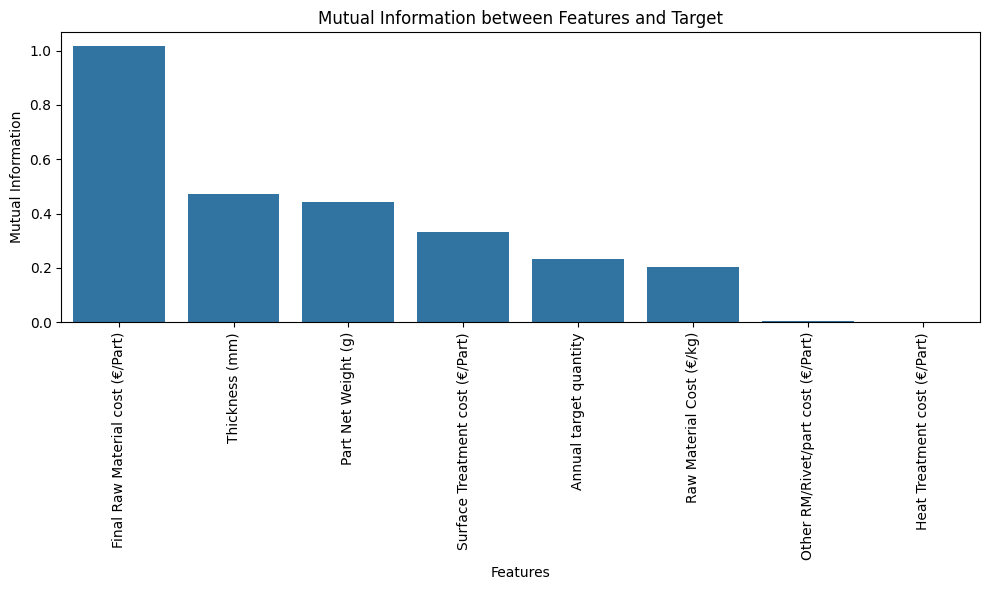

Final Raw Material cost (€/Part)     1.016378
Thickness (mm)                       0.473857
Part Net Weight (g)                  0.443212
Surface Treatment cost (€/Part)      0.331704
Annual target quantity               0.232088
Raw Material Cost (€/kg)             0.201709
Other RM/Rivet/part cost (€/Part)    0.004553
Heat Treatment cost (€/Part)         0.000000
dtype: float64


In [5]:
target_column = 'Total cost with amortization (€/part)'
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)','Other RM/Rivet/part cost (€/Part)'
]

# Check if the features and target columns exist
missing_columns = []
for column in features + [target_column]:
  if column not in df.columns:
    missing_columns.append(column)

if missing_columns:
  raise ValueError(f"The following columns are missing in the DataFrame: {', '.join(missing_columns)}")

X = df[features]
y = df[target_column]

mutual_info = mutual_info_regression(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series.index, y=mutual_info_series.values)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Features and Target")
plt.tight_layout()
plt.show()

print(mutual_info_series)

Kendall's Tau Values:
Annual target quantity: -0.397
Raw Material Cost (€/kg): 0.220
Thickness (mm): 0.405
Part Net Weight (g): 0.290
Final Raw Material cost (€/Part): 0.667
Surface Treatment cost (€/Part): 0.243
Heat Treatment cost (€/Part): -0.116
Other RM/Rivet/part cost (€/Part): 0.086
Number of marginals: 9
Shape of copula_data: (159, 9)
Copula dimension: 9
Gaussian Copula fitted


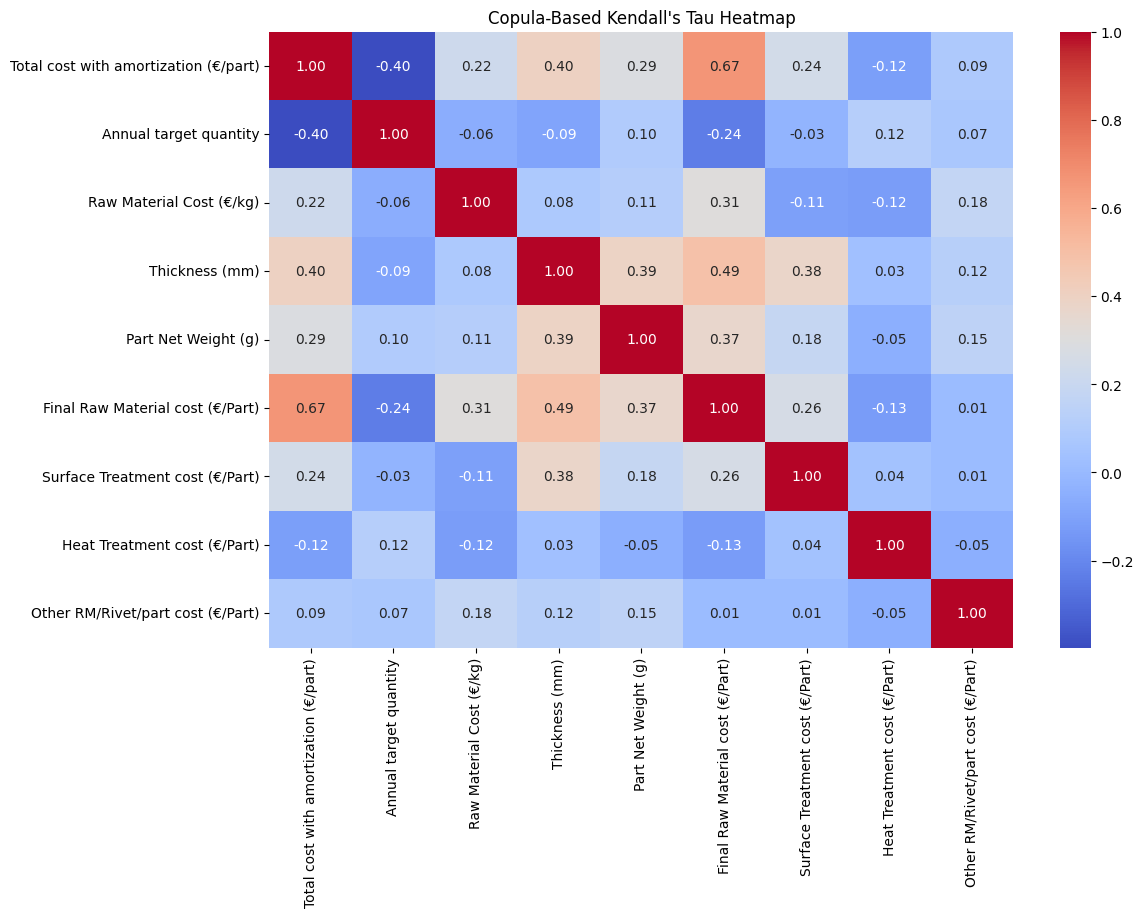

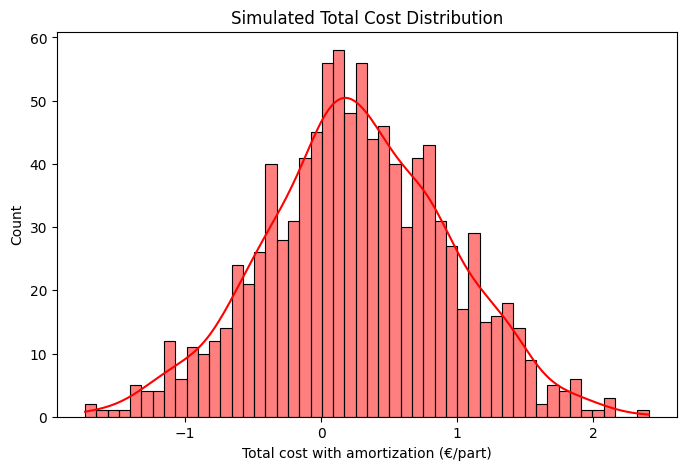

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.copula.api import ClaytonCopula, GumbelCopula, GaussianCopula, CopulaDistribution
from scipy.stats import kendalltau, norm

# Define target and features
target_column = 'Total cost with amortization (€/part)'
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)','Other RM/Rivet/part cost (€/Part)'
]

# Compute Kendall's Tau for each feature vs the target
kendall_tau_values = {feature: kendalltau(df[feature], df[target_column])[0] for feature in features}

# Print correlation values to determine dependency
print("Kendall's Tau Values:")
for feature, tau in kendall_tau_values.items():
    print(f"{feature}: {tau:.3f}")

# Convert features & target to uniform distribution (needed for copulas)
def rank_transform(series):
    return (series.rank(method='average') - 1) / (len(series) - 1)

# Ensure we are using the correct number of features + target
copula_data = df[[target_column] + features].dropna()
copula_data = copula_data.apply(rank_transform)

# Calculate the dimension for the copula (number of variables)
dim = copula_data.shape[1]

# Estimate copula parameter from Kendall's Tau
tau_mean = np.mean(list(kendall_tau_values.values()))
if tau_mean > 0.3:
    copula_type = "Gumbel"
    theta = 1 / (1 - tau_mean)
    copula = GumbelCopula(theta=theta, dim=dim)
elif tau_mean < -0.3:
    copula_type = "Clayton"
    theta = 2 * tau_mean / (1 - tau_mean)
    copula = ClaytonCopula(theta=theta, dim=dim)
else:
    copula_type = "Gaussian"
    # Create a correlation matrix for the Gaussian copula
    corr_matrix = copula_data.corr().values
    copula = GaussianCopula(corr=corr_matrix)
    theta = None  # Gaussian copula does not use theta

# Fit normal distributions to each marginal variable (target + features)
marginals = [norm(loc=df[col].mean(), scale=df[col].std()) for col in [target_column] + features]

# Debug prints
print(f"Number of marginals: {len(marginals)}")
print(f"Shape of copula_data: {copula_data.shape}")
print(f"Copula dimension: {dim}")

# Ensure the number of marginals matches the number of columns in copula_data
if len(marginals) != copula_data.shape[1]:
    raise ValueError("Number of marginals does not match the number of columns in copula_data")

# Create the copula distribution with proper marginals
copula_dist = CopulaDistribution(copula=copula, marginals=marginals)

if theta is not None:
    print(f"{copula_type} Copula fitted with parameter theta={theta:.3f}")
else:
    print(f"{copula_type} Copula fitted")

# Plot heatmap of Kendall's Tau dependencies
plt.figure(figsize=(12, 8))
sns.heatmap(copula_data.corr(method=lambda x, y: kendalltau(x, y)[0]), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Copula-Based Kendall's Tau Heatmap")
plt.show()

# Generate synthetic data from the fitted copula
simulated_data = copula_dist.rvs(1000)

# Convert to DataFrame for analysis
simulated_df = pd.DataFrame(simulated_data, columns=[target_column] + features)

# Plot simulated target cost distribution
plt.figure(figsize=(8, 5))
sns.histplot(simulated_df[target_column], bins=50, kde=True, color='red')
plt.title("Simulated Total Cost Distribution")
plt.xlabel("Total cost with amortization (€/part)")
plt.show()